In [1]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

d2l.use_svg_display()

Kernels and Data

```
积分变换
输入函数 f(y) → 经过核函数K(x,y)加权积分 → 输出新函数 g(x)
g(x) = ∫ K(x,y) × f(y) dy
#      ↑核函数    ↑原函数

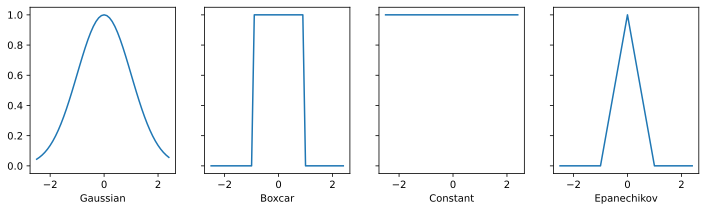

In [2]:
# Define some kernels
# 高斯核函数（也叫RBF核）
def gaussian(x):
    return torch.exp(-x**2 / 2)  # 返回 e^(-x²/2)，形状像钟形曲线

# 箱形核函数（也叫均匀核）
def boxcar(x):
    return torch.abs(x) < 1.0  # 当|x| < 1时返回True(1.0)，否则返回False(0.0)，形成矩形

# 常数核函数
def constant(x):
    return 1.0 + 0 * x  # 始终返回1.0，0*x是为了保持张量形状一致

# Epanechnikov核函数（二次核）
def epanechikov(x):
    # 返回 max(1-|x|, 0)，形成倒V形状
    return torch.max(1 - torch.abs(x), torch.zeros_like(x))
    
# 创建一个1行4列的子图，共享y轴，总图形大小为12x3英寸
fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))

# 将四个核函数放入元组
kernels = (gaussian, boxcar, constant, epanechikov)
# 对应的名称
names = ('Gaussian', 'Boxcar', 'Constant', 'Epanechikov')

# 创建x轴数据：从-2.5到2.5，步长0.1
x = torch.arange(-2.5, 2.5, 0.1)

# 同时遍历核函数、名称和子图
for kernel, name, ax in zip(kernels, names, axes):
    # 在当前子图上绘制x和对应的核函数值
    ax.plot(x.detach().numpy(), kernel(x).detach().numpy())
    # 设置子图的x轴标签为核函数名称
    ax.set_xlabel(name)

d2l.plt.show()

创建一个回归学习的数据集

In [3]:
# 定义目标函数（我们要学习的真实函数）
def f(x):
    return 2 * torch.sin(x) + x # 真实函数：正弦波 + 线性趋势

n = 40 # 训练样本数量
# 生成训练数据
x_train, _ = torch.sort(torch.rand(n) * 5) # 在[0,5]范围内随机采样40个点，然后排序
y_train = f(x_train) + torch.randn(n) # 真实函数值 + 高斯噪声（模拟真实世界的观测误差）
# 生成验证数据（用于对比和评估）
x_val = torch.arange(0, 5, 0.1) # 在[0,5]范围内等间距采样（步长0.1）
y_val = f(x_val)  # 纯净的真实函数值（无噪声）

 Attention Pooling via Nadaraya–Watson Regression

注意力机制的经典应用：Nadaraya-Watson核回归(传统Nadaraya-Watson-自己定义而不是机器学)

```
1. 距离计算
# 想象40个训练点问50个验证点："你离我有多远？"
距离矩阵 = 每个训练点 - 每个验证点
2. 相似性权重
# 核函数说："距离近的影响大，远的影响小"
权重 = kernel(距离)  # 高斯核：近的权重大，远的权重小
3. 注意力归一化
# 对每个验证点，所有训练点权重加起来等于1
注意力权重 = 权重 / 总权重
4. 加权预测
n# 最终预测 = 训练标签的加权平均
预测值 = Σ(注意力权重 × 训练标签)

In [4]:
def nadaraya_watson(x_train, y_train, x_val, kernel):
    # 计算每个训练点到每个验证点的距离矩阵
    dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
    # x_train: (40,) → (40, 1)   训练点x坐标，变成列向量
    # x_val: (50,) → (1, 50)     验证点x坐标，变成行向量  
    
    # 把距离矩阵转换成相似性权重矩阵，用的就是上面定义的高斯核函数等
    k = kernel(dists).type(torch.float32)
    
    # 按列归一化
    attention_w = k / k.sum(0)
    
    # 加权平均
    y_hat = y_train @ attention_w
    
    return y_hat, attention_w

```
假设只有：
2个训练点：[1, 3]
3个验证点：[0, 2, 4]
#第1步：重塑形状
        x_train.reshape(-1, 1) →  [[1],    # (2, 1) 竖着放
                                   [3]]
        
        x_val.reshape(1, -1)   →  [[0, 2, 4]]  # (1, 3) 横着放
#第2步：想象成表格
        [0, 2, 4]  ← 验证点（横着）
        [1]    ?  ?  ?
        [3]    ?  ?  ?
        ↑
        训练点（竖着）
#第3步：逐个格子计算
        [0, 2, 4]
        [1]  1-0=1   1-2=-1   1-4=-3
        [3]  3-0=3   3-2=1    3-4=-1
#最终结果
        dists = [[1, -1, -3],
                 [3,  1, -1]]  # (2, 3) 矩阵

Let’s have a look at the kind of estimates that the different kernels produce.

In [5]:
def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
    # 创建1行4列的子图（对应4种核函数）
    fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))
    
    # 遍历4种核函数，分别绘图
    for kernel, name, ax in zip(kernels, names, axes):
        # 用当前核函数做预测，得到预测值和注意力权重
        y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, kernel)
        
        if attention:  # 注意力模式：画热图
            pcm = ax.imshow(attention_w.detach().numpy(), cmap='Reds')
        else:  # 正常模式：画曲线
            ax.plot(x_val, y_hat)      # 预测曲线（蓝色）
            ax.plot(x_val, y_val, 'm--')  # 真实曲线（洋红虚线）
            ax.plot(x_train, y_train, 'o', alpha=0.5)  # 训练点（圆点）
            
        ax.set_xlabel(name)  # 设置子图标题（核函数名）
        
        if not attention:
            ax.legend(['y_hat', 'y'])  # 添加图例
            
    if attention:
        fig.colorbar(pcm, ax=axes, shrink=0.7)  # 为热图添加颜色条

```
# 曲线图的三条线：
🟣 洋红虚线(y_val) = 真实函数-验证集
🔵 蓝色实线(y_hat) = 用训练集学出的预测
🔵 散落圆点 = 训练数据
#曲线图和热力图
都用nadaraya_watson计算：两个图都基于同一个函数 ✓

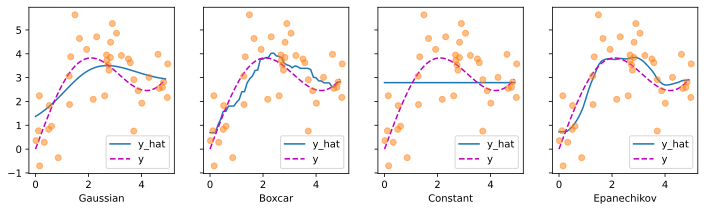

In [6]:
plot(x_train, y_train, x_val, y_val, kernels, names)

热力图 = 用nadaraya_watson函数计算的attention_w矩阵 = 训练点对验证点的"注意力分配表"

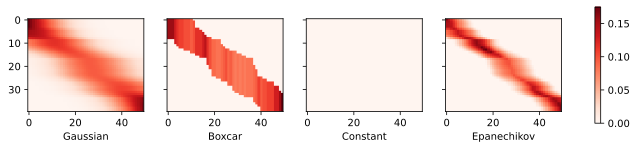

In [7]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

Adapting Attention Pooling

```
对比1：
    之前：4种不同类型的核函数
    kernels = (gaussian, boxcar, constant, epanechikov)  # 4种不同形状
    现在：4种相同类型但不同参数的高斯核
    sigmas = (0.1, 0.2, 0.5, 1)  # 4个不同的σ参数
    kernels = [gaussian_with_width(sigma) for sigma in sigmas]  # 4个不同"宽度"的高斯核
对比2：数学公式σ
    # 之前的标准高斯核
    gaussian(x) = e^(-x²/2)
    # 现在的可调宽度高斯核  
    gaussian_with_width(x, σ) = e^(-x²/(2σ²))

In [8]:
sigmas = (0.1, 0.2, 0.5, 1)
names = ['Sigma ' + str(sigma) for sigma in sigmas]

def gaussian_with_width(sigma):
    # 返回一个lambda匿名函数，这个函数使用传入的sigma值
    return (lambda x: torch.exp(-x**2 / (2*sigma**2)))
    
# 使用列表推导式，为每个sigma值创建一个对应的高斯核函数
kernels = [gaussian_with_width(sigma) for sigma in sigmas]

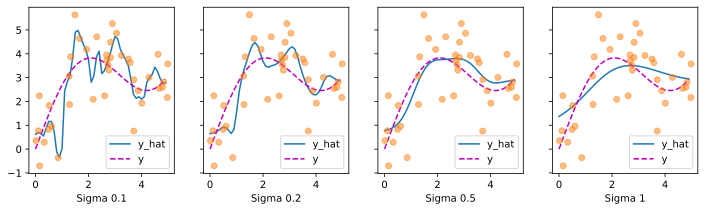

In [9]:
plot(x_train, y_train, x_val, y_val, kernels, names)

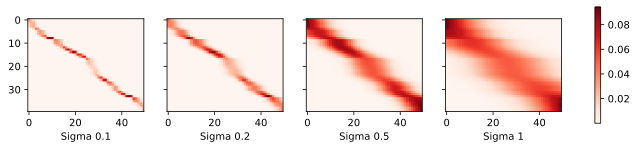

In [10]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)